# <center> Capstone проект №3 <br> Прогнозирование временных рядов на карте

## <center> Неделя 3 <br> Прогнозирование ряда со сложной сезонностью

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model
import itertools
from tqdm import tqdm_notebook
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных за май 2016 года

In [2]:
data = pd.read_csv('Prepare_data/prepare_data_2016-05.csv',
                   index_col='time',parse_dates=['time'],
                   dtype={'count':int,'region':int})

In [3]:
train_data = data[data['region'] == 1231]
train_data = train_data.drop(columns = 'region')
T = len(train_data.index)

Критерий Дики-Фуллера: p=0.000413


<Figure size 1296x1152 with 0 Axes>

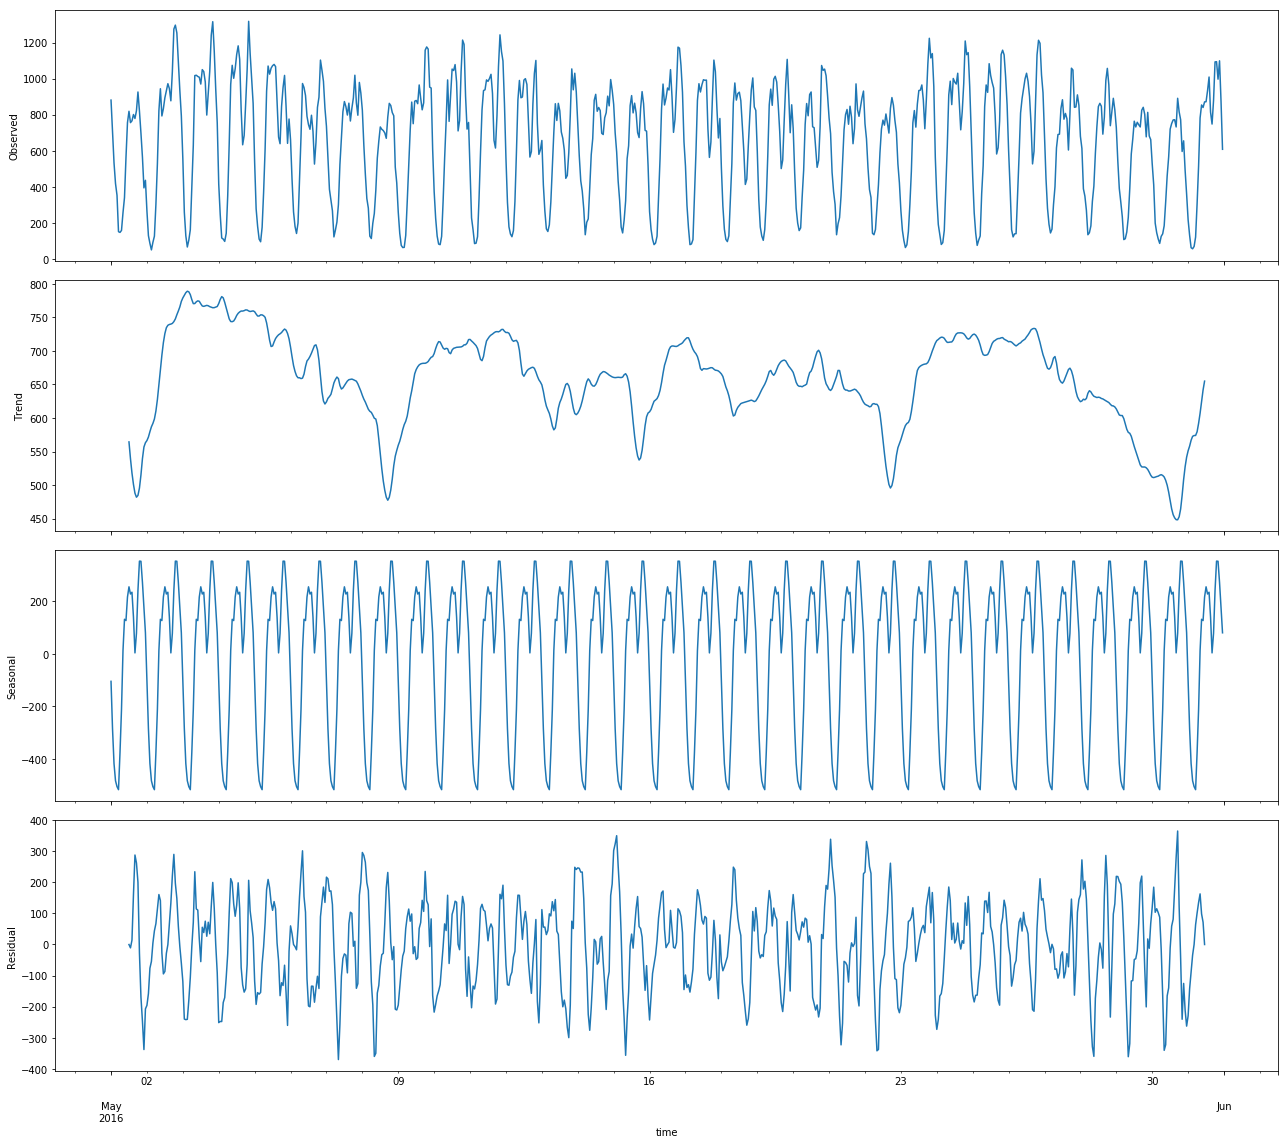

In [4]:
figure(figsize(18,16))
sm.tsa.seasonal_decompose(train_data['count']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['count'])[1])
show()

Хоть и гипотеза о нестационарности отвергается, видно, что ряд содержит и недельную и суточную сезонность.
В модели ARIMA можно учесть только одну из них. Недельную сезонность и учтем за счет за счёт регрессионной компоненты, а суточную непосредственно в ARIMA.

### Регрессионные признаки

Создадим два типа признаков:

- Фурье-гармоники

- бинарные признаки дней недели

In [5]:
def generate_exog(T, k=5):
    exog_sin = np.zeros((T,k))
    exog_cos = np.zeros((T,k))
    T = np.arange(1, T + 1)
    for i in range(k):
        exog_sin[:,i] = np.sin(T * 2 * pi * (i+1) / 168)
        exog_cos[:,i] = np.cos(T * 2 * pi * (i+1) / 168)
    exog = np.concatenate((exog_sin,exog_cos),axis=1)
    return pd.DataFrame(exog)

In [6]:
train_exog = generate_exog(T, 5)
train_exog_weekday = pd.get_dummies(x[0].weekday() for x in train_data.itertuples())
train_exog = pd.concat([train_exog, train_exog_weekday],axis=1)

На созданных признаках обучим линейную регрессию

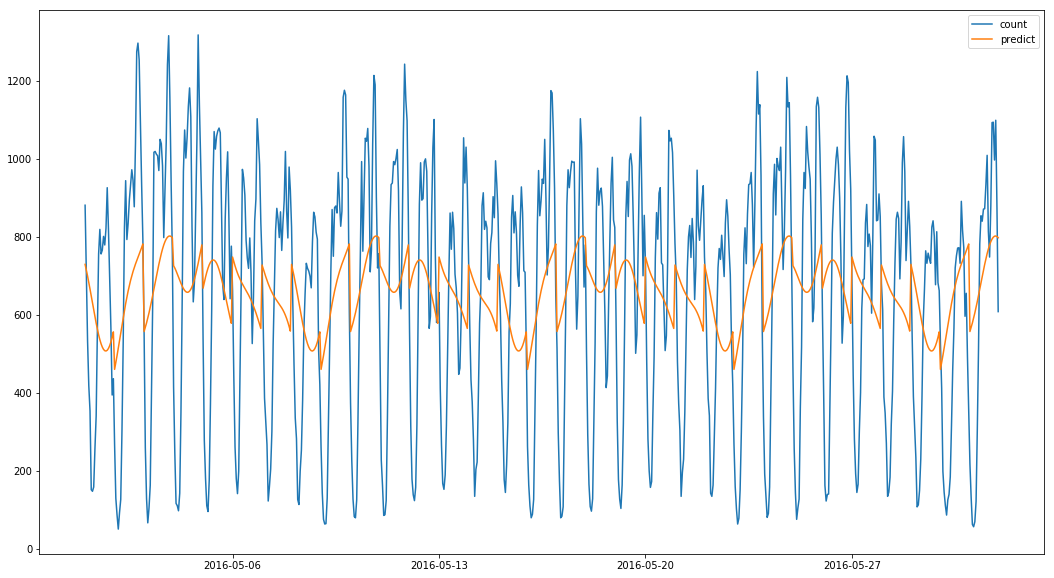

In [7]:
lin_model = linear_model.LinearRegression().fit(train_exog,train_data['count'])
train_data['predict'] = lin_model.predict(train_exog)
figure(figsize=(18,10))
plot(train_data.index,train_data['count'])
plot(train_data.index,train_data['predict'])
legend()
show()

In [8]:
train_data['residual'] = train_data['count'] - train_data['predict']

### Стационарность

Критерий Дики-Фуллера: p=0.000000


<Figure size 1296x1152 with 0 Axes>

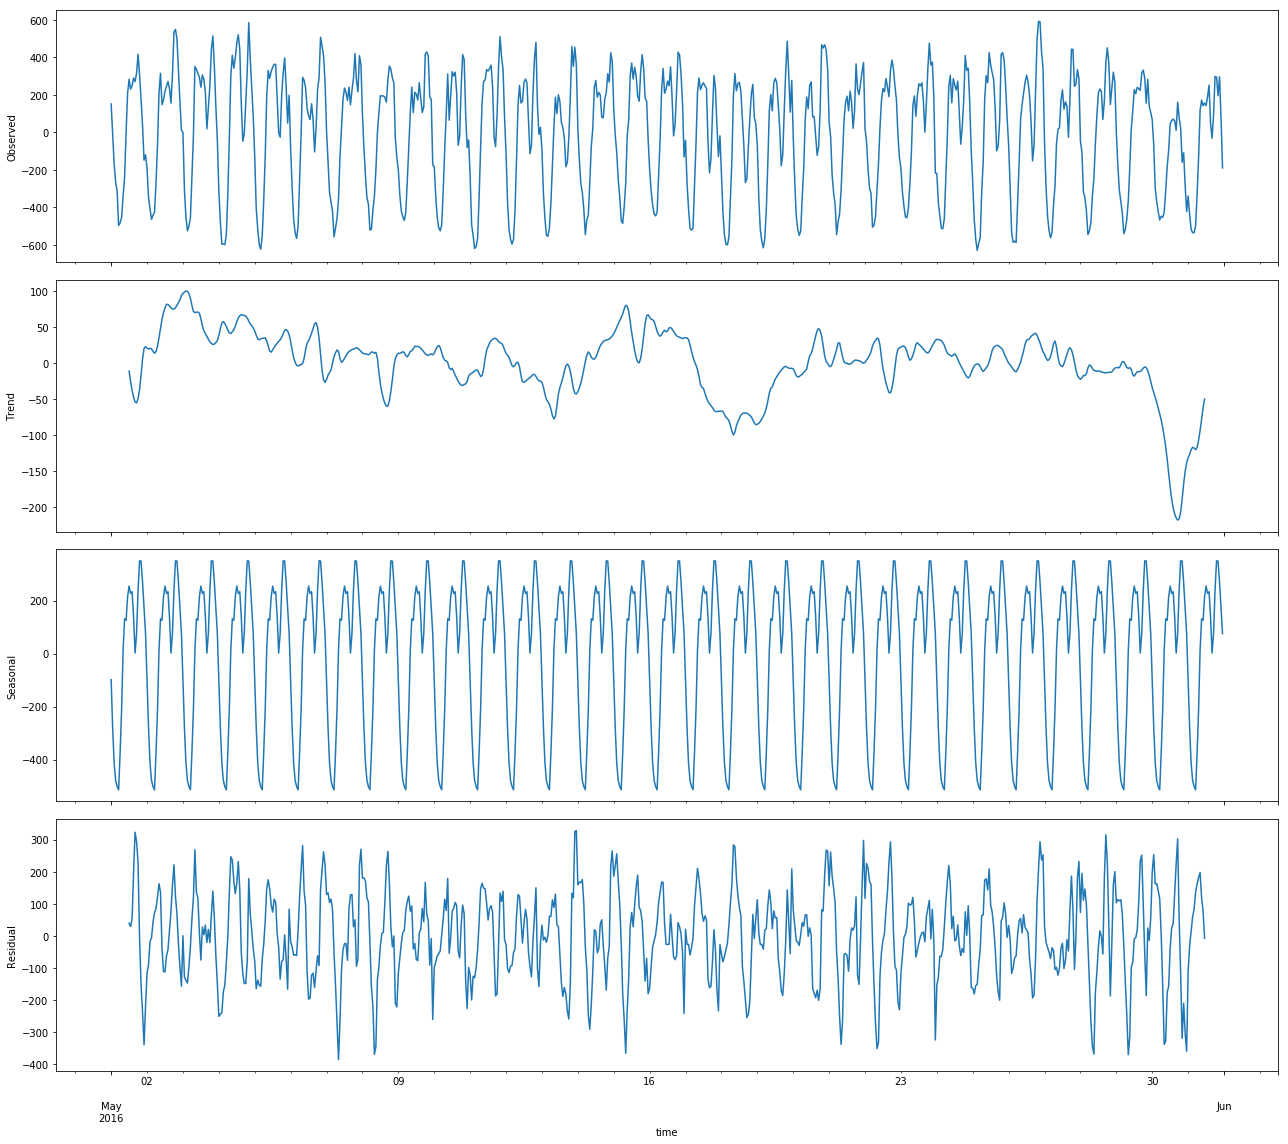

In [9]:
figure(figsize(18,16))
sm.tsa.seasonal_decompose(train_data['residual']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['residual'])[1])
show()

Гипотеза о нестационарности опять отвергается,но визуально ряд содержит тренд и суточную сезонность. В остатках осталась недельная сезонность.
Попробуем сезонное (суточное) дифференцирование.

In [10]:
train_data['residual_diff'] = train_data['residual'] - train_data['residual'].shift(24)

Критерий Дики-Фуллера: p=0.000000


<Figure size 1296x1296 with 0 Axes>

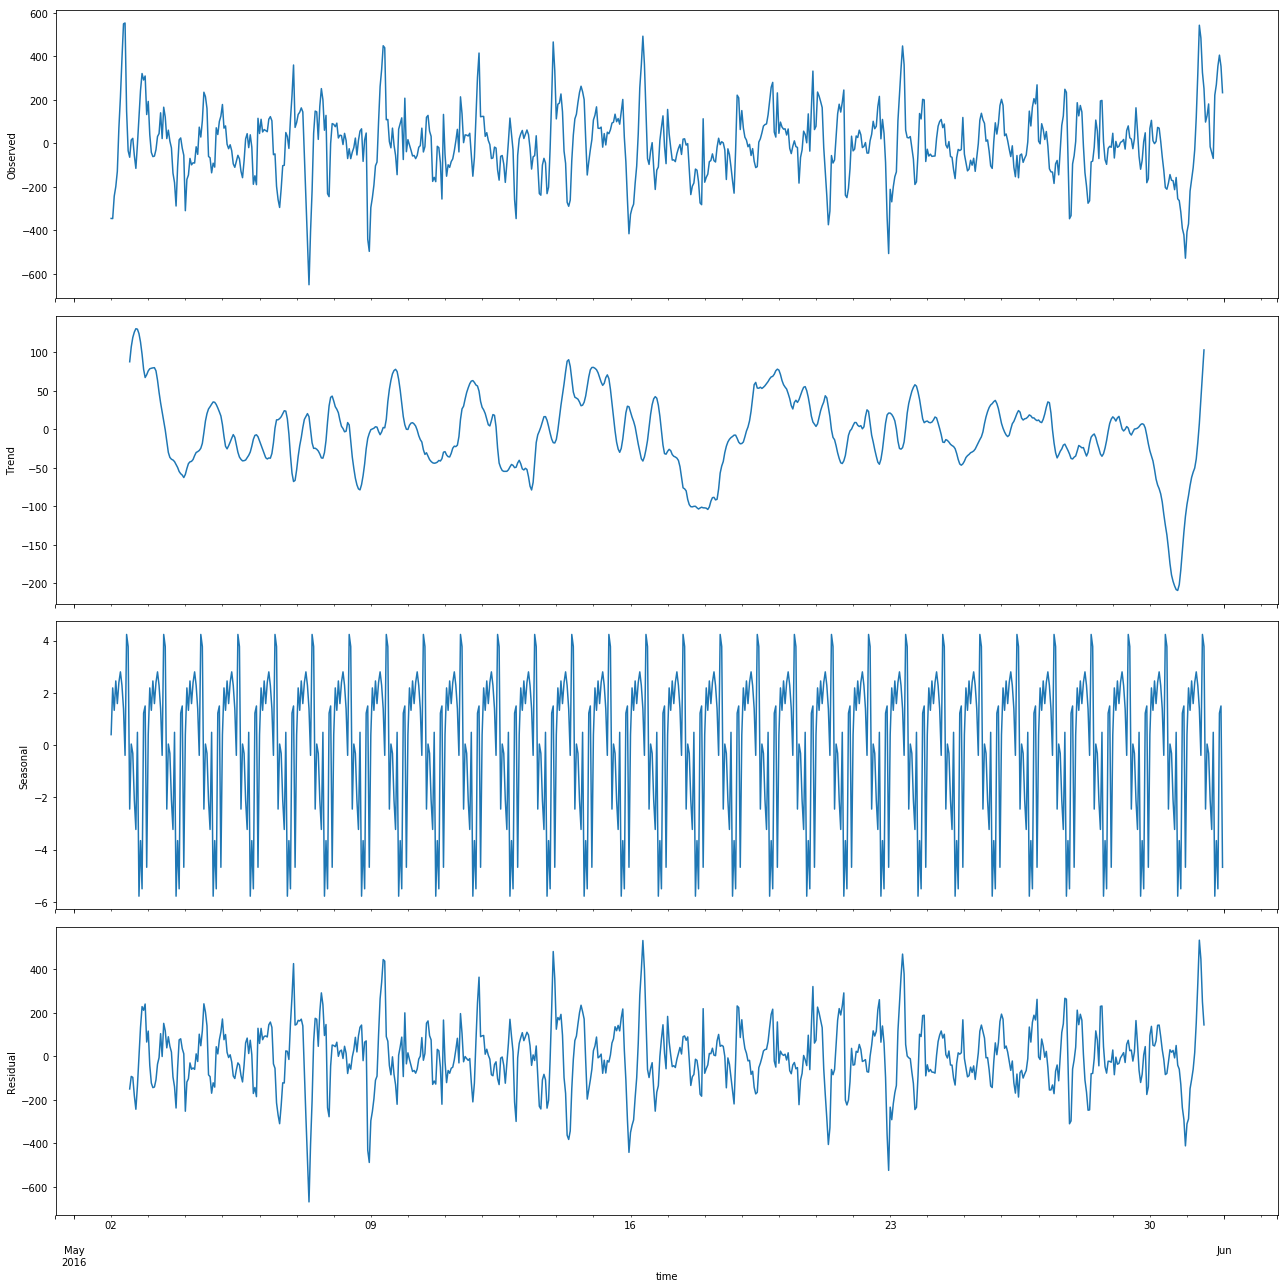

In [11]:
figure(figsize(18,18))
sm.tsa.seasonal_decompose(train_data['residual_diff'].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['residual_diff'].dropna())[1])
show()

Суточная сезонность ушла, но тренд остался. Не обращаем внимания на Критерий Дики-Фуллера и сделаем еще одно дифференцирование.

In [12]:
train_data['residual_diff2'] = train_data['residual_diff'] - train_data['residual_diff'].shift(1)

Критерий Дики-Фуллера: p=0.000000


<Figure size 1296x1296 with 0 Axes>

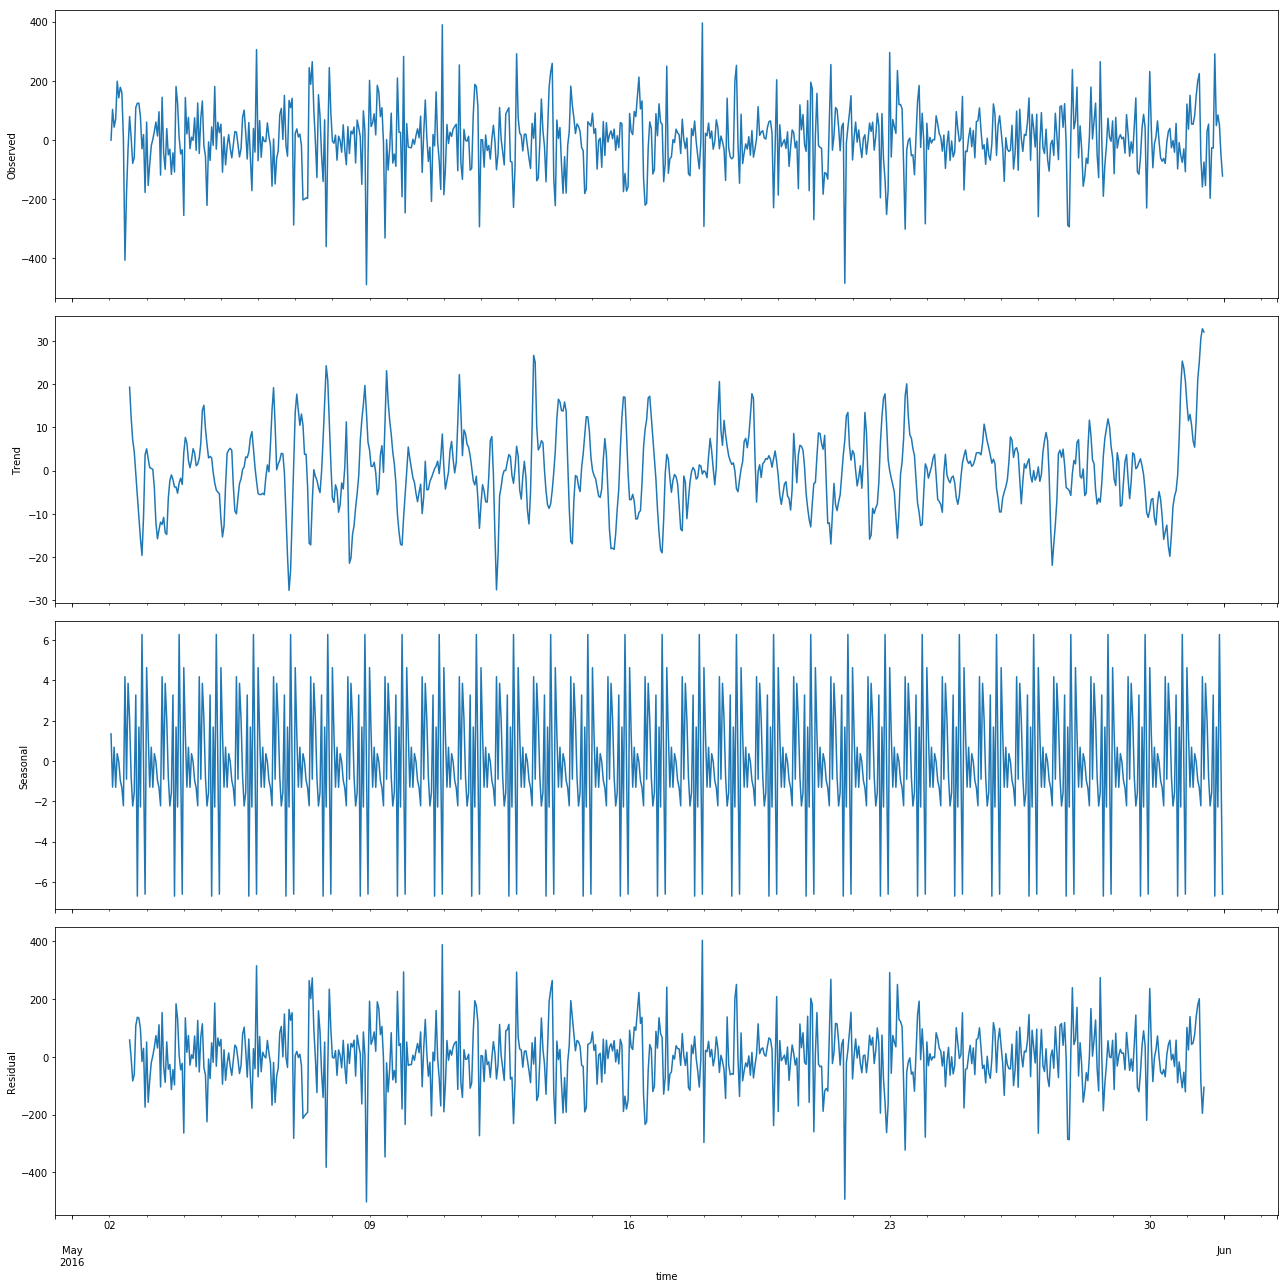

In [13]:
figure(figsize(18,18))
sm.tsa.seasonal_decompose(train_data['residual_diff2'].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['residual_diff2'].dropna())[1])
show()

In [14]:
train_data['residual_diff3'] = train_data['residual_diff2'] - train_data['residual_diff2'].shift(1)

Критерий Дики-Фуллера: p=0.000000


<Figure size 1296x720 with 0 Axes>

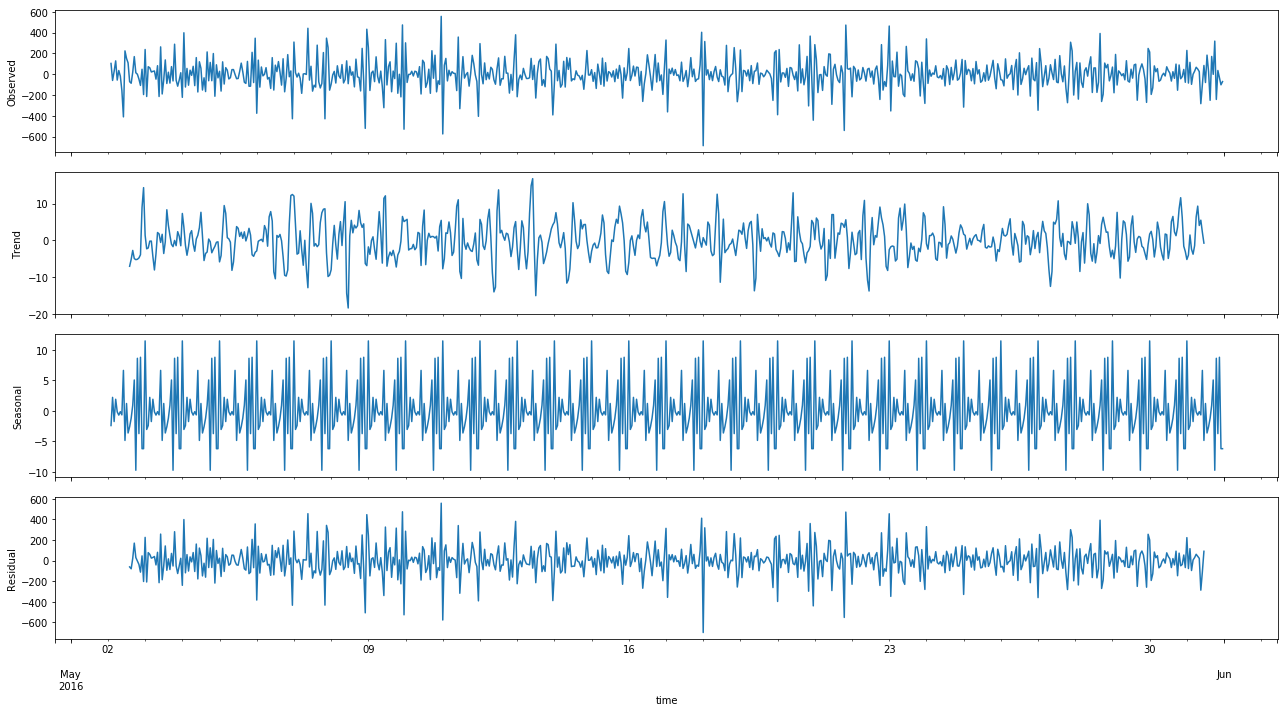

In [15]:
plt.figure(figsize(18,10))
sm.tsa.seasonal_decompose(train_data['residual_diff3'].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_data['residual_diff3'].dropna())[1])
plt.show()

Тренд ушел, ярко выраженной сезонности нет, остатки похожи на шум. Гипотеза о нестационарности отвергается. Можно приступать к настройке ARIMA.

### Подбор модели

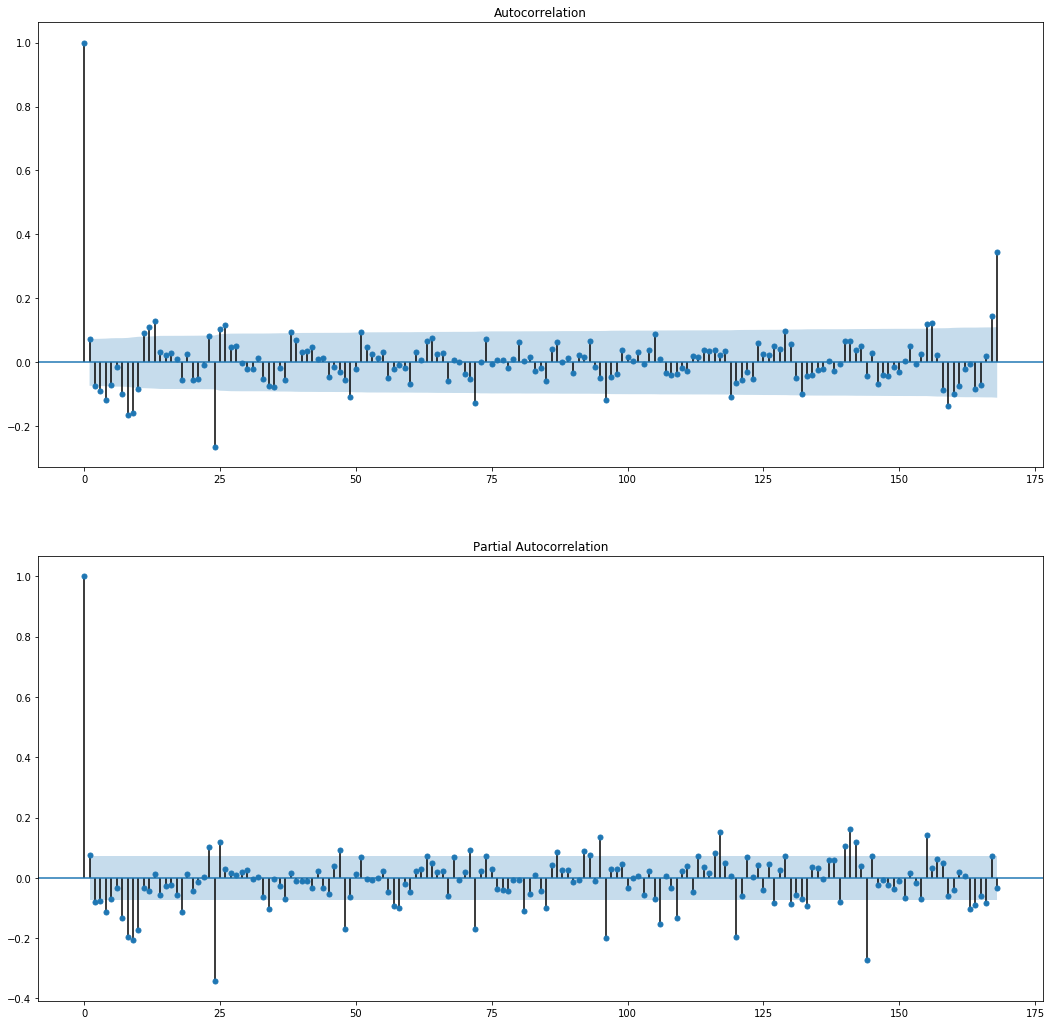

In [16]:
figure(figsize(18,18))
ax = subplot(211)
sm.graphics.tsa.plot_acf(train_data['residual_diff2'].dropna().values, lags=168, ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(train_data['residual_diff2'].dropna().values, lags=168, ax=ax)
show()

Начальные приближения: Q=7, q=13, P=6, p=10

In [17]:
ps = range(0, 11)
d=1
qs = range(0, 14)
Ps = range(0, 7)
D=1
Qs = range(0, 8)

In [19]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8624

А вот тут начинается ад)
Не судите строго,но так как время на перебор стало стремиться к бесконечности, я решил обучить только одну модель на начальных приближения, это конечно будет не оптимальная модель с точки зрения критерия Акаике, но качество прогноза уменьшиться не должно.
Также я обучался на остатках регрессии для уменьшения времени. В итоге одна модель обучалась около пары часов...
Планирую повторить на AWS инстанс.

In [17]:
best_model=sm.tsa.statespace.SARIMAX(train_data['residual'].resample('H').sum(),
                                     order=(10, 1, 13),
                                     seasonal_order=(6, 1, 7, 24)).fit(disp=-1)
best_model.save('best_model')

/home/mycacu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Подбирать модель надо было так:

In [ ]:

%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm_notebook(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_data['count'].values, exog = train_exog.values,
                                        order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 24),
                                        ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [20]:
best_model = sm.load('best_model')

In [21]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                  
============================================================================================
Dep. Variable:                             residual   No. Observations:                  744
Model:             SARIMAX(10, 1, 13)x(6, 1, 7, 24)   Log Likelihood               -4141.335
Date:                              Sun, 08 Jul 2018   AIC                           8356.670
Time:                                      12:54:16   BIC                           8526.051
Sample:                                  05-01-2016   HQIC                          8422.065
                                       - 05-31-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5994      3.845     -0.156      0.876      -8.135       6.937
ar.L2         -0.4207      3.822     -0.110      0.912      -7.912       7.071
ar.L3         -0.2723      2.237     -0.122      0.903      -4.657       4.113
ar.L4         -0.2776      1.134     -0.245      0.807      -2.501       1.946
ar.L5         -0.3904      1.953     -0.200      0.842      -4.219       3.438
ar.L6         -0.0574      1.941     -0.030      0.976      -3.862       3.747
ar.L7         -0.2828      1.544     -0.183      0.855      -3.310       2.744
ar.L8         -0.2467      1.294     -0.191      0.849      -2.782       2.289
ar.L9         -0.1850      1.815     -0.102      0.919      -3.743       3.373
ar.L10        -0.2650      1.587     -0.167      0.867      -3.376       2.846
ma.L1          0.4669      3.852      0.121      0.904      -7.083       8.017
ma.L2          0.1293      3.667      0.035      0.972      -7.058       7.316
ma.L3         -0.0695      2.760     -0.025      0.980      -5.480       5.341
ma.L4         -0.0857      1.934     -0.044      0.965      -3.876       3.705
ma.L5          0.0176      1.414      0.012      0.990      -2.755       2.790
ma.L6         -0.3221      1.187     -0.271      0.786      -2.648       2.003
ma.L7         -0.0963      2.175     -0.044      0.965      -4.360       4.167
ma.L8         -0.1370      1.922     -0.071      0.943      -3.904       3.630
ma.L9         -0.2159      0.957     -0.226      0.822      -2.092       1.660
ma.L10        -0.1181      1.390     -0.085      0.932      -2.843       2.607
ma.L11        -0.1620      1.246     -0.130      0.897      -2.605       2.281
ma.L12        -0.1093      0.915     -0.119      0.905      -1.903       1.684
ma.L13         0.0355      0.210      0.169      0.865      -0.375       0.447
ar.S.L24      -0.7925      0.320     -2.479      0.013      -1.419      -0.166
ar.S.L48      -0.8618      0.214     -4.020      0.000      -1.282      -0.442
ar.S.L72      -0.7003      0.211     -3.314      0.001      -1.115      -0.286
ar.S.L96      -0.8138      0.224     -3.628      0.000      -1.253      -0.374
ar.S.L120     -0.8902      0.241     -3.694      0.000      -1.363      -0.418
ar.S.L144     -0.6153      0.321     -1.917      0.055      -1.244       0.014
ma.S.L24       0.0455      0.351      0.130      0.897      -0.642       0.733
ma.S.L48       0.2170      0.254      0.853      0.394      -0.282       0.716
ma.S.L72      -0.0693      0.238     -0.291      0.771      -0.536       0.397
ma.S.L96       0.2010      0.258      0.780      0.435      -0.304       0.706
ma.S.L120      0.2766      0.268      1.032      0.302      -0.249       0.802
ma.S.L144     -0.0717      0.308     -0.233      0.816      -0.676       0.532
ma.S.L168     -0.2699      0.301     -0.896      0.370      -0.860       0.320
sigma2      8487.7804    712.295  

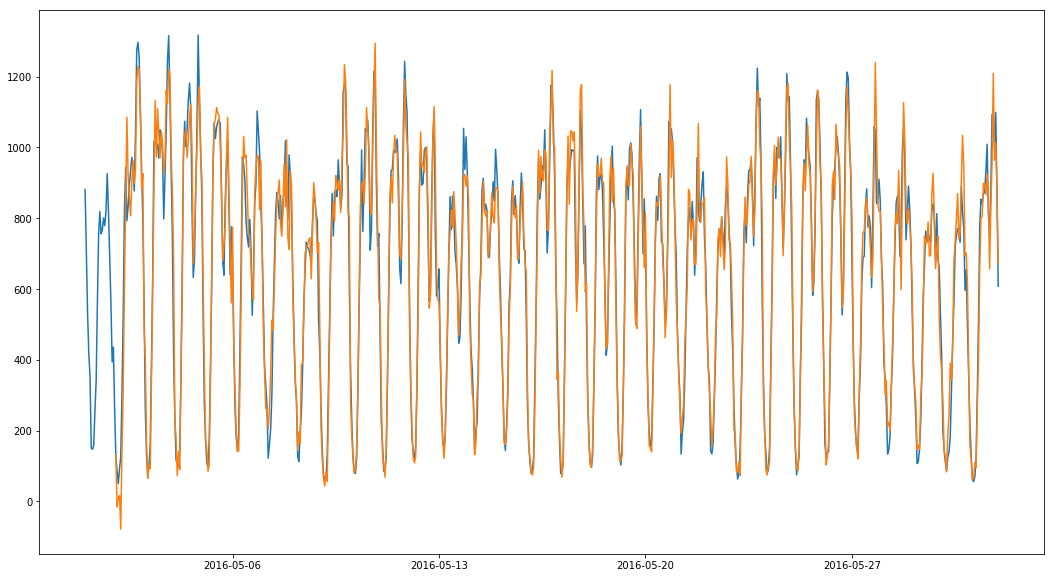

In [22]:
figure(figsize=(18,10))
plot(train_data.index, train_data['count'])
plot(best_model.fittedvalues[25:]+train_data.predict[25:])
show()

Качество модель вполне хорошее, посмотрим на остатки

Критерий Стьюдента: p=0.835578
Критерий Дики-Фуллера: p=0.000000


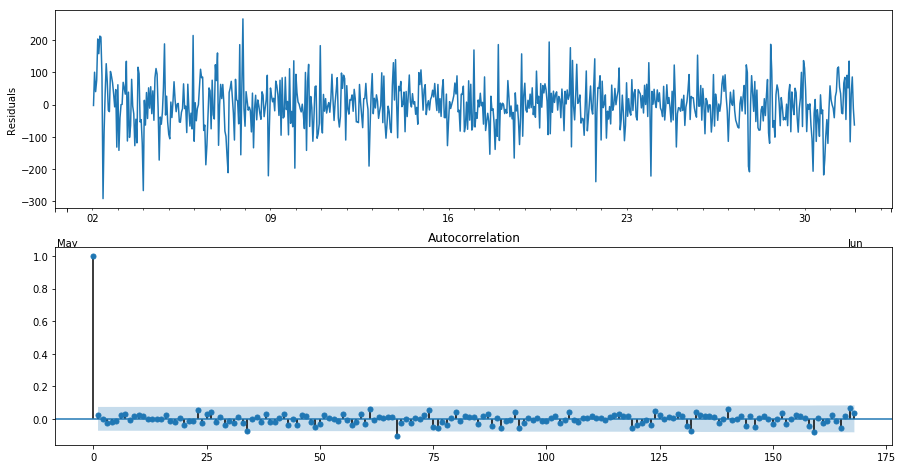

In [23]:
figure(figsize(15,8))
subplot(211)
best_model.resid[25:].plot()
ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[25:].values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[25:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[25:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).